In [1]:
# author: Carlos F. Dietrich (carlos.dietrich@tum.de)
# reviewer: Francisco J. Guerrero-Gonzalez
# version: 1.0.0

Copyright 2023, Professorship of Lunar and Planetary Exploration, Technical University of Munich.

Permission is hereby granted, free of charge, to any person obtaining a copy of this model and associated documentation files, without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the models, and to permit persons to whom the model is furnished to do so, subject to the following conditions:

1. The above copyright notice and this permission notice shall be included in all copies or substantial portions of the model, as well as reference to the author(s) listed above. Scientific publications which use this model shall cite the [ISRULib documentation site](https://wiki.tum.de/display/lpe/ISRULib) attributing credit to the named authors in the documentation.

2. The model is provided without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose, and non-infringement. In no event shall the authors or copyright holders be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the model or the use or other dealings in the model.

# Vibratory Conveyor

In [2]:
# Python Libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

**Model Description**

In vibratory handling, a motor moves a trough or a tube with a vibratory motion in a diagonal direction, as shown in the picture below. Through this motion, particles are lifted and moved forward through the trough. Particles can be transported horizontally or upwards at a slight angle. A spiral can be used to move material vertically.

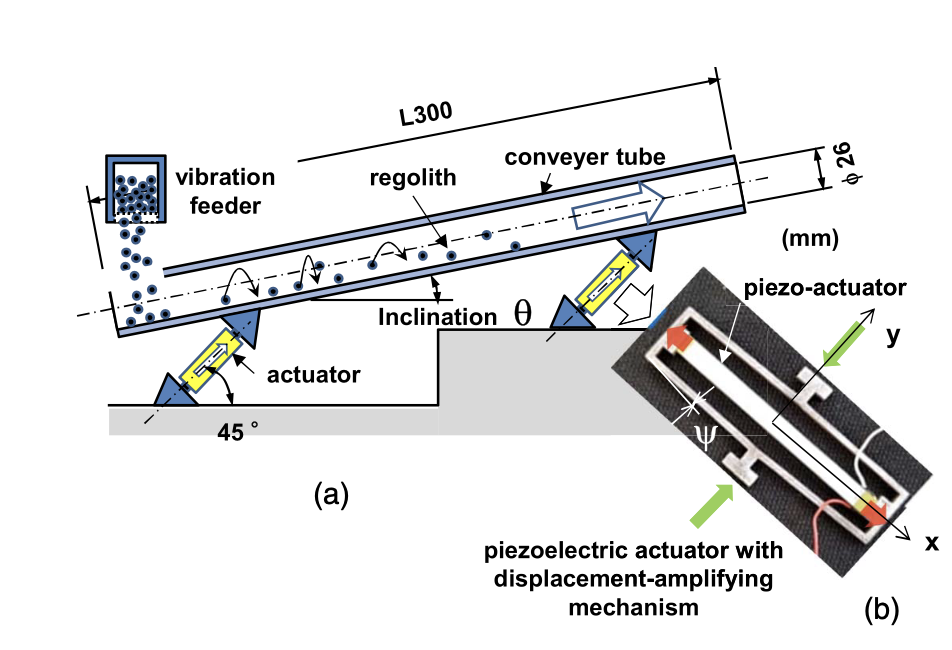

In [3]:
# Include here a descriptive figure of the component (model)
display.Image("figs/Vibration.png") # Schematic depiction of a vibratory conveyor and actuator (Kawamoto, 2020)

**Model Assumptions, Simplifications and future Improvements**

The model assumes that the vibration is created with piezoelectric actuators and vibration ampliefiers, which amplifiy the amplitude of the oscillation. In particlar, the piezoelectric actuator AE0203D44H40F is used as in (Kawamoto, 2020).

The model dimensions are defined in **1. Inputs**. The power consumption is estimated with the power drawn by each piezoelectric actuator. It is assumed that every 30 cm one actuator is applied. The dependency of the number of actuators with the mass flow and system size must be further evaluated.

The mass of the system is estimated through geometric assumptions. It is assumed that the system consists of a tube (either straight or as helix) and of actuators every 30 cm.  The helix angle is 10 degrees. The mass of the piezoelectric actuator is an assumption. It includes the piezoelectric actuator, an amplifier and the structure that holds them to the tube. 

The mass flow and the transport velocity is modeled according to Woodcock & Mason (1987). The flow is estimated with the acceleration the bulk material receives in the moving direction. This only partly takes into account the lunar conditions, since it are modelled via experimental factors obtained from terrestial cases. Furthermore, it is assumed that the tube is filled up to 20% with granular material.

**Disclamer:** The performance based on this model should be treated with caution. The behavior of bulk material is rather difficult to predict, and the transport situation is complex.  It is recommended to determine the performance with experimental testing (Woodcock & Mason, 1987).

Future improvements could include:
- Other geometries instead of a tube could be included, e.g., open transport, or squared trough shape.
- Other actuators could be included which operate at different frequencies, with different power requirements.
- The mass flow could be modeled with more detail to better represent the bulk material conditions on the Moon. A starting point could be  the work carried out by Adachi et al. (2017).
- Model the bulk material behavior in more detail (e.g., through DEM simulations).
- Model the number of actuators as function of system dimensions and mass flow.

The rest of the assumptions and possible improvements are explained thoroughly in **1. Inputs and 3. Model Body**

## 1. Inputs

In [4]:
# The same dimensions as Kawamoto (2020) are considered to make the model comparable. Dimensions can be adapted to individual requirements. 
D_in   = 0.026 # m | Inner diameter of tube
D_out  = 0.03 # m | Outer diameter of tube
Length = 0.3 # m | Length of tube, it can be adapted to individual requirements. Kawamoto (2020) -> 0.3 m

# For vertical transportation only. Dimensions can be adapted to individual requirements. 
# Vertical transportation assumes a helix-shaped vibratory conveyor. 
Height      = 0.3 # m | Height of the helix
RadiusHelix = 0.25 # m | Radius of the helix
HelixAngle  = 10 # deg | Helix angle, assumed at 10 deg as good compromise between steepness and flatness

# Piezoelectric actuators
piezoelectric_voltage     = 150 # V | Piezoelectric voltage (AE0203D44H40F actuator, L: 40 mm, W: 3 mm, T: 2 mm, NEC TOKIN Corp., Japan | Kawamoto, 2020)
piezoelectric_capacitance = 0.82e-6 # F | Capacitance of the piezoelectric actuator (MMECH)
piezoelectric_force       = 200 # N | Piezoelectric actuator force (used for verification)
piezoelectric_mass        = 0.1 # kg | Rough assumption including the actuator and amplifier and the structural mass to attach them to the tube 

# The amplitude, beta angle, and frequency are based on Kawamoto (2020) 
amplitude = 0.0003 # m | Amplitude of actuator and amplifier (Kawamoto, 2020)
beta      = 45  # deg | Angle of the actuators with respect to the ground (Kawamoto, 2020)
frequency = 150 # Hz | Frequency of vibration (Kawamoto, 2020)

# Trasport factors required for mass flow calculation. Based on (Woodcock & Masen, 1987; pp. 358-380)
transport_eff = 0.8 # | Estimated transport efficency
Fm = 0.7 # - | Factor that considers different material properties. It needs to be determined experimentally, but would normally be less than unity for low load densities and small grain sizes
Fh = 1 # - | Factor that considers the depth of bulk material on trough. Value varies from unity for small depths to about 0.75 for depths of 300 mm
Fj = 1 # - | Factor that considers the slope of the trough. Value is around unity for horizontal conveying and upward conveying to about 15°, but decreases rapidly for steeper slopes.

## 2. Constants

In [5]:
pi = np.pi # -

gMoon = 1.62 # m/s2 | Gravitational acceleration on the Moon

Regolith_density = 1500 # kg/m3 | Bulk regolith density (Schreiner et al., 2016)
Tube_density = 2700 # kg/m3 density of tube for aluminum

## 3. Model Body

In [6]:
HelixAngle = HelixAngle*pi/180 # rad | Converting helix angle from deg to rad
beta       = beta*pi/180 # rad | Converting angle of the actuators with respect to the ground from deg to rad

In [7]:
n_actuators = 1 + np.floor(Length/0.3) # - | Number of actuators, assumed 1 actuator every 30 cm.

# Mass for longitudinal transport
Area_Tube_Material   = pi*(D_out**2-D_in**2)/4 #m2 | Area of tube material
Mass_Tube_per_Length = Area_Tube_Material*Tube_density # kg/m | Mass of tube per length

tube_mass = Mass_Tube_per_Length*Length # kg | Mass of tube
piezoelectric_masses = piezoelectric_mass*n_actuators # kg | Mass of all actuators
total_mass = tube_mass + piezoelectric_masses # kg | Total mass of the entire system

# Power for longitudinal transport
piezoelectric_current = piezoelectric_voltage*pi*piezoelectric_capacitance*frequency # A | Piezoelectric actuator current (PiezoDrive)
piezoelectric_power_per_actuator = piezoelectric_current*piezoelectric_voltage # W | Power for one piezoelectric actuator
total_power = piezoelectric_power_per_actuator*n_actuators # W | Total power consumption of the entire system

# Assuming that the tube is filled 20% with granular material. The area covered by material is determined
AreaBulk = 0.2*(pi/4)*D_in**2 # m2 | Tube area filled with material assuming that 20% of is filled w/ granular material

# An relevant parameter when modelling vibratory conveyors is the ratio of the vertical acceleration of the trough to 
# the gravitational acceleration, since this determines the point at which the flight phase begins. 
# The maximum value of this parameter, which would normally be determined at the design stage by chosing:
# a frequency, amplitude and angle of oscillation, is sometimes called the "dynamic material coefficient" (Woodcock & Chase, 1987)
DynamicMaterialCoefficient = (amplitude*(2*pi*frequency)**2*np.sin(beta))/gMoon # - | Dynamic material coefficient, only used for verification of factors (Woodcock & Chase, 1987)
K = DynamicMaterialCoefficient/(np.sin(beta)) # - | K factor, only used for verification of factors (Woodcock & Chase, 1987)

# The transport velocity is the maximum velocity including the experimental trasport factors. Max velocity is described by:
# the amplitude, frequency, and beta angle (Woodcock & Chase, 1987)
TransportVelocity = transport_eff*Fm*Fh*Fj*amplitude*2*pi*frequency*np.cos(beta) # m/s | Transport velocity of bulk material
m_out = Regolith_density*AreaBulk*TransportVelocity # kg/s | mass flow of bulk granular material

amplificator_factor = 5 # - | A displacement amplifier is used by Kawamoto (2020). Accordingly, the force is 5 times weaker.
MoveableMass = piezoelectric_force/amplificator_factor/gMoon # | kg, Force the actuators can move, only used for verification.

MassPerRate  = total_mass/m_out # kg/(kg/s) | Mass per unit of mass flow
PowerPerRate = total_power/m_out # W/(kg/s) | Power per unit of mass flow

# Modifications necessary for vertical transportation (helix)
# Geometric dimensions
h_coil          = 2*pi*RadiusHelix*np.tan(HelixAngle) # m | Height is gained in one rotation
n_coils         = Height/h_coil # - | number of coils in the helix
DistanceOneCoil = 2*pi*RadiusHelix/np.cos(HelixAngle) # m | Distance that bulk material travels in one coil
DistanceHelix   = n_coils*DistanceOneCoil # m | arc length of entire helix

n_actuators_vertical = 1 + np.floor(DistanceHelix/0.3) # - | Number of actuators, assumed 1 actuator every 30 cm.

# Mass for helicoidal transport
tube_mass_vertical = Mass_Tube_per_Length*DistanceHelix # kg | mass of helix-tube

piezoelectric_masses_vertical = n_actuators_vertical*piezoelectric_mass # kg | mass of all actuators on a helix-tube
total_mass_vertical = tube_mass_vertical + piezoelectric_masses_vertical # kg | Total mass of vertical conveyor system

# Power for helicoidal transport
total_power_vertical = n_actuators_vertical*piezoelectric_power_per_actuator # W | Total power consumption of the vertical conveyor system

TransportVelocityVertical= (np.cos(HelixAngle)**2)*transport_eff*Fm*Fh*Fj*amplitude*2*pi*frequency*np.cos(beta) # m/s | Transport velocity (along track), expected to decrease with increasing angle

m_out_vertical = Regolith_density*AreaBulk*TransportVelocityVertical # kg/s | mass flow in vertical conveyor systems

MassPerRateVertical  = total_mass_vertical/m_out_vertical # kg/(kg/s) | Mass per unit of mass flow for vertical conveyor systems
PowerPerRateVertical = total_power_vertical/m_out_vertical # W/(kg/s) | Power per unit of mass flow for vertical conveyor systems

## 4. Outputs

In [14]:
print('\033[1m'+'Longitudinal Conveyor System'+'\033[0m')
print("Velocity:          ",round(TransportVelocity,3),"m/s")
print("Mass flow:         ",round(m_out,4),"kg/s")
print("Mass:              ",round(total_mass,3),"kg")
print("Power:             ",round(total_power,1),"W")
print()
print("Mass  per flowrate:",round(MassPerRate,2),"kg/(kg/s)")
print("Power per flowrate:",round(PowerPerRate,1),"W/(kg/s)")
print()
print('\033[1m'+'Helix Conveyor System'+'\033[0m')
print("Velocity:          ",round(TransportVelocityVertical,3),"m/s (along coil)")
print("Mass flow:         ",round(m_out_vertical,4),"kg/s")
print("Mass:              ",round(total_mass_vertical,3),"kg")
print("Power:             ",round(total_power_vertical,1),"W")
print()
print("Mass  per flowrate:",round(MassPerRateVertical,1),"kg/(kg/s)")
print("Power per flowrate:",round(PowerPerRateVertical,1),"W/(kg/s)")

Longitudinal Conveyor System
Velocity:           0.112 m/s
Mass flow:          0.0178 kg/s
Mass:               0.343 kg
Power:              17.4 W

Mass  per flowrate: 19.21 kg/(kg/s)
Power per flowrate: 975.1 W/(kg/s)

Helix Conveyor System
Velocity:           0.109 m/s (along coil)
Mass flow:          0.0173 kg/s
Mass:               1.421 kg
Power:              52.2 W

Mass  per flowrate: 82.1 kg/(kg/s)
Power per flowrate: 3016.2 W/(kg/s)


## References

M. Adachi, K. Hamazawa, Y. Mimuro, H. Kawamoto, Vibration transport system for lunar and Martian regolith using dielectric elastomer actuator, Journal of Electrostatics 89 (2017) 88-98, https://doi.org/10.1016/j.elstat.2017.08.003

H. Kawamoto, Vibration Transport of Lunar Regolith for In Situ Resource Utilization Using Piezoelectric Actuators with Displacement-Amplifying Mechanism, Journal of Aerospace Engineering 33 (3) (2020) 04020014, https://doi.org/10.1061/(ASCE)AS.1943-5525.0001128

Micromechatronics, Inc. (MMech), AE0203D44H40 piezoelectric actuator, https://www.mmech.com/tokin-actuators/nec-tokin-resin-coated/nec-ae0203d44h40f

PiezoDrive, Driving Piezoelectric Actuators Calculators, https://www.piezodrive.com/calculators/

S.S. Schreiner, J.A. Dominguez, L. Sibille, J.A. Hoffman, Thermophysical property models for lunar regolith, Adv. Space Res. 57 (5) (2016) 1209–1222, http://dx.doi.org/10.1016/j.asr.2015.12.035 

C.R. Woodcock, J.S. Mason, Bulk Solids Handling: An Introduction to the Practice and Technology, 1987, https://doi.org/10.1007/978-94-009-2635-6